In [15]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from PIL import Image
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms, utils, datasets
from torch.utils.data import Dataset, DataLoader
from skimage import io, transform, data
from sklearn.model_selection import train_test_split

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")


In [2]:
ROOT_PATH = r'C:\Users\Dell\Desktop\machine learning\Kaggle\Kaggle_superbowllsh\Superbowl'

train_data = os.path.join(ROOT_PATH, "train")
test_data = os.path.join(ROOT_PATH, "test")


In [3]:
dirty_bowls = os.path.join(train_data, "dirty")
file_names = [f for f in os.listdir(dirty_bowls)
                      if f.endswith(".jpg")]
dict = pd.DataFrame({'image': file_names,
                    'label': 'dirty'
                    })
dict.to_csv('dirty_dict.csv', index = False)


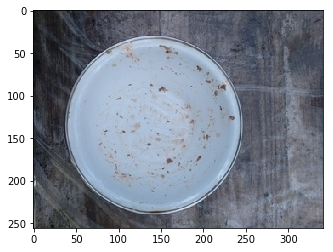

In [4]:
def show_bowls(image):
    """Show image with bowls"""
    plt.imshow(image)

plt.figure()
show_bowls(io.imread(os.path.join(dirty_bowls, dict.iloc[0,0])))
plt.show()

In [5]:
class BowlDataset(Dataset):

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.bowl_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.bowl_frame)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir,
                                self.bowl_frame.iloc[idx, 0])
        image = io.imread(img_name)
        label = self.bowl_frame.iloc[idx, 1:].values

        sample = {'image': image, 'label': label}

        if self.transform:
            sample = self.transform(sample)

        return sample

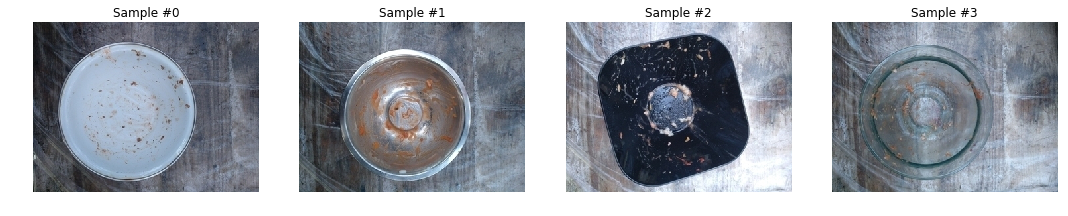

In [6]:
bowl_dataset = BowlDataset(csv_file=os.path.join(ROOT_PATH, "dirty_dict.csv"),
                                    root_dir=dirty_bowls)

fig = plt.figure(figsize=(15,5))

for i in range(len(bowl_dataset)):
    sample = bowl_dataset[i]

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    show_bowls(sample['image'])

    if i == 3:
        plt.show()
        break

In [7]:
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image = sample['image']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))

        return {'image': img}


class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image = sample['image']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h,
                      left: left + new_w]

        return {'image': image}


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image = sample['image']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image)}

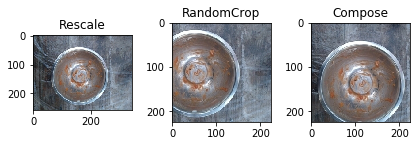

In [8]:
scale = Rescale(256)
crop = RandomCrop(224)
composed = transforms.Compose([Rescale(256),
                               RandomCrop(224)])

# Apply each of the above transforms on sample.
fig = plt.figure()
sample = bowl_dataset[1]
for i, tsfrm in enumerate([scale, crop, composed]):
    transformed_sample = tsfrm(sample)

    ax = plt.subplot(1, 3, i + 1)
    plt.tight_layout()
    ax.set_title(type(tsfrm).__name__)
    show_bowls(**transformed_sample)

plt.show()

In [9]:
transformed_dataset = BowlDataset(csv_file=os.path.join(ROOT_PATH, "dirty_dict.csv"),
                                           root_dir=dirty_bowls,
                                           transform=transforms.Compose([
                                               Rescale(256),
                                               RandomCrop(224),
                                               ToTensor()
                                           ]))

for i in range(len(transformed_dataset)):
    sample = transformed_dataset[i]

    print(i, sample['image'].size())

    if i == 3:
        break

0 torch.Size([3, 224, 224])
1 torch.Size([3, 224, 224])
2 torch.Size([3, 224, 224])
3 torch.Size([3, 224, 224])


0 torch.Size([4, 3, 224, 224])
1 torch.Size([4, 3, 224, 224])
2 torch.Size([4, 3, 224, 224])
3 torch.Size([4, 3, 224, 224])


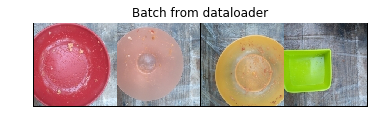

In [14]:
dataloader = DataLoader(transformed_dataset, batch_size=4,
                        shuffle=True)


# Helper function to show a batch
def show_bowls_batch(sample_batched):
    """Show image with landmarks for a batch of samples."""
    images_batch = sample_batched['image']
    batch_size = len(images_batch)
    im_size = images_batch.size(2)
    grid_border_size = 2

    grid = utils.make_grid(images_batch)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

    plt.title('Batch from dataloader')

for i_batch, sample_batched in enumerate(dataloader):
    print(i_batch, sample_batched['image'].size())

    # observe 4th batch and stop.
    if i_batch == 3:
        plt.figure()
        show_bowls_batch(sample_batched)
        plt.axis('off')
        plt.ioff()
        plt.show()
        break

In [17]:
# torchvision

data_transform = transforms.Compose([
        transforms.RandomSizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
hymenoptera_dataset = datasets.ImageFolder(root=train_data,
                                           transform=data_transform)
dataset_loader = torch.utils.data.DataLoader(hymenoptera_dataset,
                                             batch_size=4, shuffle=True)

In [23]:
for i_batch, sample_batched in enumerate(dataset_loader):
    print(i_batch, sample_batched)


0 [tensor([[[[ 0.9646,  0.9303,  0.9132,  ...,  1.3755,  1.3755,  1.3927],
          [ 0.9646,  0.9132,  0.8789,  ...,  1.3242,  1.3242,  1.3413],
          [ 0.9646,  0.8961,  0.8104,  ...,  1.2385,  1.2385,  1.2728],
          ...,
          [ 0.2796,  0.2967,  0.3138,  ..., -0.4568, -0.4739, -0.4568],
          [ 0.2624,  0.2796,  0.3309,  ..., -0.4397, -0.4568, -0.4397],
          [ 0.2453,  0.2796,  0.3309,  ..., -0.4226, -0.4397, -0.4397]],

         [[ 1.0455,  0.9755,  0.9055,  ...,  1.3782,  1.3782,  1.3957],
          [ 1.0280,  0.9405,  0.8704,  ...,  1.3431,  1.3431,  1.3606],
          [ 1.0105,  0.9055,  0.8004,  ...,  1.2731,  1.2906,  1.3256],
          ...,
          [-1.3004, -1.2829, -1.2829,  ..., -1.6681, -1.6856, -1.6681],
          [-1.3179, -1.3004, -1.3004,  ..., -1.6506, -1.6681, -1.6506],
          [-1.3354, -1.3179, -1.3004,  ..., -1.6506, -1.6506, -1.6506]],

         [[ 1.2805,  1.2108,  1.1411,  ...,  1.6988,  1.6640,  1.6640],
          [ 1.2805,  1.1934

          [-0.1487, -0.1661, -0.1661,  ...,  0.5659,  0.4962,  0.4614]]]]), tensor([1, 0, 1, 1])]
2 [tensor([[[[ 1.5468,  1.4612,  1.3413,  ...,  0.1939,  0.7077,  0.9303],
          [ 1.5297,  1.4098,  1.2728,  ...,  0.1939,  0.6906,  1.1358],
          [ 1.3927,  1.3413,  1.2899,  ...,  0.3994,  0.7077,  1.1358],
          ...,
          [ 1.6838,  1.6495,  1.6838,  ...,  0.6049,  0.4851,  0.3994],
          [ 1.6495,  1.6495,  1.7523,  ...,  0.4851,  0.4166,  0.5536],
          [ 1.7180,  1.6838,  1.5639,  ...,  0.3994,  0.4508,  0.6563]],

         [[ 1.8333,  1.7458,  1.6408,  ...,  0.4853,  1.0455,  1.2731],
          [ 1.8158,  1.7108,  1.5532,  ...,  0.5028,  1.0630,  1.5007],
          [ 1.6583,  1.6057,  1.5707,  ...,  0.7129,  1.0455,  1.5007],
          ...,
          [ 2.0084,  1.9734,  2.0084,  ...,  0.8004,  0.6779,  0.5903],
          [ 1.9909,  1.9734,  2.0784,  ...,  0.6954,  0.6254,  0.7304],
          [ 2.0609,  1.9909,  1.8859,  ...,  0.6078,  0.6604,  0.8704]],

 

          [-1.3164, -1.2990, -1.2990,  ...,  0.7054,  0.7054,  0.6879]]]]), tensor([1, 0, 1, 1])]
4 [tensor([[[[-1.7240, -1.7240, -1.7240,  ..., -1.2103, -1.1932, -1.1932],
          [-1.6898, -1.7240, -1.7240,  ..., -1.1932, -1.1760, -1.1589],
          [-1.6555, -1.7069, -1.7412,  ..., -1.1760, -1.1418, -1.1075],
          ...,
          [ 0.3994,  0.4851,  0.5707,  ..., -1.2103, -1.1075, -1.0562],
          [ 0.4166,  0.5022,  0.5707,  ..., -1.1589, -1.0904, -1.0904],
          [ 0.4337,  0.5193,  0.5707,  ..., -1.1247, -1.0733, -1.1075]],

         [[-1.6155, -1.6331, -1.6506,  ..., -1.0553, -1.0378, -1.0203],
          [-1.5980, -1.6331, -1.6506,  ..., -1.0378, -1.0203, -0.9853],
          [-1.5805, -1.6331, -1.6681,  ..., -1.0203, -0.9853, -0.9503],
          ...,
          [ 0.7829,  0.8704,  0.9580,  ..., -1.0028, -0.8978, -0.8452],
          [ 0.8179,  0.8880,  0.9580,  ..., -0.9503, -0.8803, -0.8803],
          [ 0.8354,  0.9055,  0.9580,  ..., -0.9153, -0.8627, -0.8978]],

 

          [ 1.6640,  1.6117,  1.7511,  ...,  0.0431, -0.1138, -0.4275]]]]), tensor([1, 1, 0, 1])]
6 [tensor([[[[-1.5870, -1.3644, -1.2788,  ..., -0.5253, -0.3027, -0.4226],
          [-1.6384, -1.3473, -1.3473,  ..., -0.4911, -0.3027, -0.3369],
          [-1.6213, -1.4329, -1.3987,  ..., -0.4568, -0.5082, -0.2342],
          ...,
          [-0.8335, -0.7308, -0.8678,  ...,  0.2624,  0.2111,  0.2453],
          [-0.7308, -0.8164, -0.8507,  ...,  0.3309,  0.3138,  0.3481],
          [-0.6965, -0.7479, -0.6794,  ...,  0.4508,  0.5536,  0.3652]],

         [[-1.4230, -1.2479, -1.1779,  ..., -0.2325, -0.0224, -0.1450],
          [-1.5105, -1.2479, -1.2479,  ..., -0.2150, -0.0224, -0.0574],
          [-1.5105, -1.3354, -1.3004,  ..., -0.1625, -0.2150,  0.0651],
          ...,
          [-0.6352, -0.5301, -0.6702,  ...,  0.5553,  0.4853,  0.5553],
          [-0.5301, -0.6176, -0.6176,  ...,  0.6078,  0.5903,  0.6604],
          [-0.4951, -0.5476, -0.4601,  ...,  0.7304,  0.8354,  0.6779]],

 

          [ 1.9603,  1.9254,  1.9080,  ..., -0.7587, -0.7761, -0.7761]]]]), tensor([0, 0, 0, 1])]
8 [tensor([[[[ 0.8961,  0.9132,  1.1015,  ...,  0.2111,  0.2111,  0.0398],
          [ 0.9988,  1.0159,  1.0502,  ...,  0.3309,  0.1597, -0.0287],
          [ 1.1015,  1.2214,  1.0502,  ...,  0.3652,  0.2624,  0.1083],
          ...,
          [ 0.3309,  0.3138,  0.2967,  ...,  0.1768,  0.2282,  0.2453],
          [ 0.2282,  0.2624,  0.2624,  ...,  0.1254,  0.1083,  0.0398],
          [ 0.2111,  0.2624,  0.2796,  ...,  0.1083,  0.0912,  0.0227]],

         [[ 1.3606,  1.3606,  1.5532,  ...,  0.6779,  0.6954,  0.4853],
          [ 1.4657,  1.4832,  1.5007,  ...,  0.8004,  0.6254,  0.4153],
          [ 1.5357,  1.6583,  1.5007,  ...,  0.8529,  0.7304,  0.5378],
          ...,
          [ 0.3803,  0.3627,  0.3452,  ...,  0.2927,  0.3803,  0.4153],
          [ 0.3277,  0.3627,  0.3627,  ...,  0.2577,  0.2752,  0.2402],
          [ 0.3102,  0.3627,  0.3803,  ...,  0.2227,  0.2577,  0.2052]],

 

          [ 0.3568,  0.3393,  0.3219,  ..., -0.3230, -0.3753, -0.3927]]]]), tensor([0, 0, 0, 1])]


In [103]:
# loading train dataset

def load_data(data_dir):

    directories = [d for d in os.listdir(data_dir)]

    labels = []
    images = []
    
    for d in directories:
        label_dir = os.path.join(data_dir, d)
        file_names = [os.path.join(label_dir, f)
                      for f in os.listdir(label_dir)
                      if f.endswith(".jpg")]
        for f in file_names:
            image = torch.from_numpy(data.imread(f))
            images.append(image)

            labels.append(d)
        
    return images, labels

train_images, train_labels = load_data(train_data)

index_cleaned = [index for index, item in enumerate(train_labels) if item == 'cleaned']
index_dirty = [index for index, item in enumerate(train_labels) if item == 'dirty']

In [104]:
# loading test dataset

test_images = []
test_id = [re.match(r'\d*', f).group(0) 
                      for f in os.listdir(test_data)
                      if f.endswith(".jpg")]

file_names = [os.path.join(test_data, f)
                      for f in os.listdir(test_data)
                      if f.endswith(".jpg")]
for f in file_names:
    image = torch.from_numpy(data.imread(f))
    test_images.append(image)


In [105]:
# let's print first four bowls of train dataset

def print_images(dataset, num):
    
    fig = plt.figure(figsize = (15, 5*(num // 4)))

    for i in range(len(dataset)):
        sample = dataset[i]

        ax = plt.subplot(num // 4, 4, i + 1)
        plt.tight_layout()
        ax.set_title('Sample #{}'.format(i))
        ax.axis('off')

        plt.imshow(sample)

        if i == num - 1:
            plt.show()
            break
            

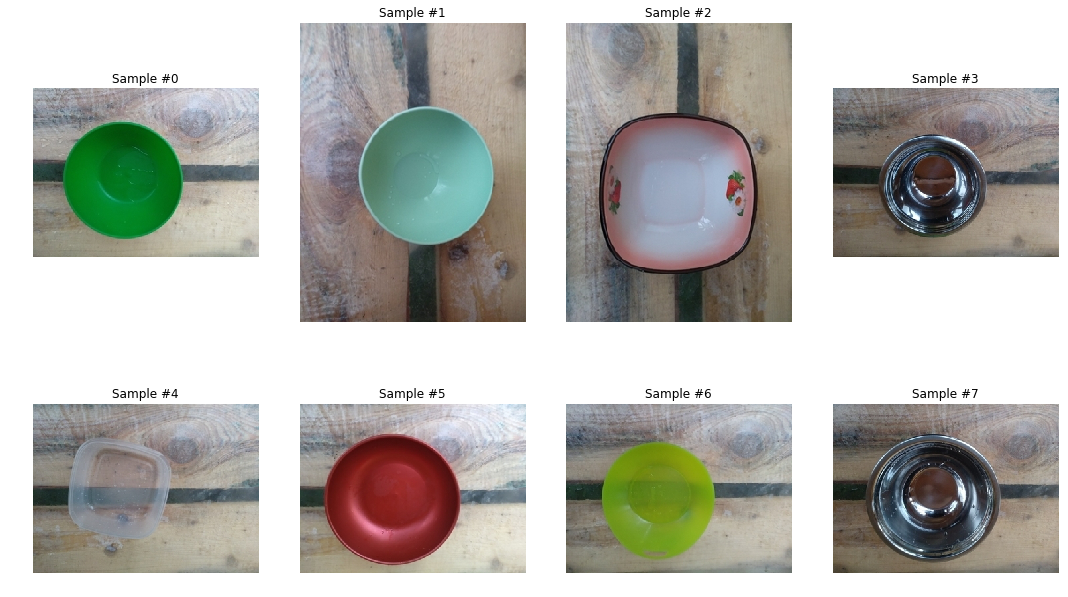

In [107]:
# cleaned bowls

print_images(train_images, 8)

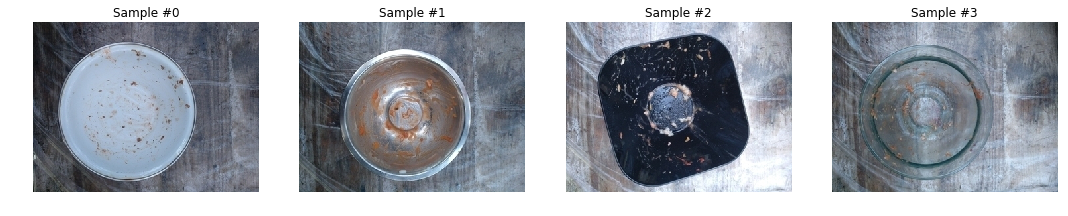

In [73]:
# dirty bowls

print_images(train_images[index_dirty], 4)

In [109]:
# let's use cross-validation for our task

train_X, val_X, train_y, val_y = train_test_split(train_images, train_labels, test_size = 0.2, stratify = train_labels)

In [110]:
class Flattener(nn.Module):
    def forward(self, x):
        batch_size, *_ = x.shape
        return x.view(batch_size, -1)

In [111]:
# let's try to use basic model on initial data

nn_model = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(4),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(4),    
            Flattener(),
            nn.Linear(64*2*2, 10),
          )

nn_model.type(torch.FloatTensor)
loss = nn.CrossEntropyLoss().type(torch.FloatTensor)
optimizer = optim.Adam(nn_model.parameters(), lr=1e-1, weight_decay=1e-4)

In [112]:
def train_model(model, train_X, val_X, train_y, val_y, loss, optimizer, num_epochs):    
    loss_history = []
    train_history = []
    val_history = []
    for epoch in range(num_epochs):
        model.train() # Enter train mode
        
        # train_X = torch.from_numpy(train_X)
        prediction = model(train_X)    
        loss_value = loss(prediction, train_y)
        optimizer.zero_grad()
        loss_value.backward()
        optimizer.step()

        train_accuracy = compute_accuracy(model, prediction, train_y)
        
        val_X = torch.from_numpy(val_X)
        prediction = model(val_X)
        val_accuracy = compute_accuracy(model, prediction, val_y)
        
        loss_history.append(float(loss_value))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        
        print("Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (ave_loss, train_accuracy, val_accuracy))
        
    return loss_history, train_history, val_history
        
def compute_accuracy(model, prediction, label):
    
    _, indices = torch.max(prediction, 1)
    correct_samples = 0
    total_samples = 0
    
    correct_samples += torch.sum(indices == label)
    total_samples += label.shape[0]
    
    return float(correct_samples) / total_samples

loss_history, train_history, val_history = train_model(nn_model, train_X, val_X, train_y, val_y, loss, optimizer, 5)

TypeError: conv2d(): argument 'input' (position 1) must be Tensor, not list

In [117]:
labels = pd.DataFrame(train_labels)
labels.to_csv('labels.csv', index=False)